In [1]:
# Importamos las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Configuramos el estilo de las gráficas
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 6))

# Fijamos la semilla para reproducibilidad
SEED = 100495991

# Cargamos los datos
data = pd.read_csv('semillas.csv')

# Exploramos los datos
print("Dimensiones del dataset:", data.shape)
print("\nPrimeras 5 filas:")
print(data.head())

# Información estadística
print("\nEstadísticas descriptivas:")
print(data.describe())

# Verificamos valores nulos
print("\nValores nulos por columna:")
print(data.isnull().sum())

# Separamos las features y la clase (solo para evaluación posterior)
X = data.drop('clase', axis=1)
y = data['clase']

print("\nDistribución de clases:")
print(y.value_counts())

Dimensiones del dataset: (210, 8)

Primeras 5 filas:
    area  perimetro  compacidad  longitud  anchura  asimetria  surco  clase
0  15.26      14.84      0.8710     5.763    3.312      2.221  5.220      1
1  14.88      14.57      0.8811     5.554    3.333      1.018  4.956      1
2  14.29      14.09      0.9050     5.291    3.337      2.699  4.825      1
3  13.84      13.94      0.8955     5.324    3.379      2.259  4.805      1
4  16.14      14.99      0.9034     5.658    3.562      1.355  5.175      1

Estadísticas descriptivas:
             area   perimetro  compacidad    longitud     anchura   asimetria  \
count  210.000000  210.000000  210.000000  210.000000  210.000000  210.000000   
mean    14.847524   14.559286    0.870999    5.628533    3.258605    3.700201   
std      2.909699    1.305959    0.023629    0.443063    0.377714    1.503557   
min     10.590000   12.410000    0.808100    4.899000    2.630000    0.765100   
25%     12.270000   13.450000    0.856900    5.262250    2

<Figure size 1000x600 with 0 Axes>

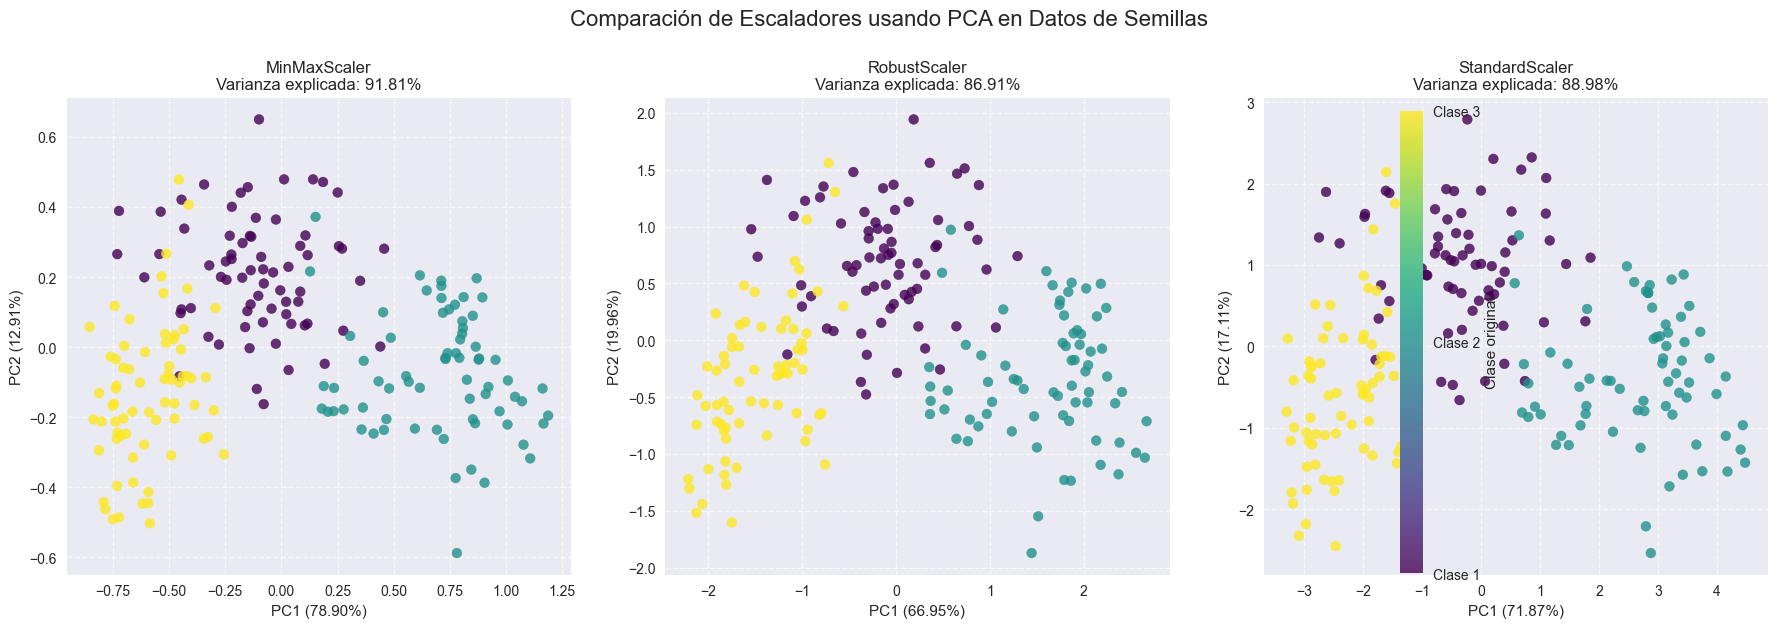

In [2]:
# Función para aplicar PCA con diferentes escaladores y visualizar resultados
def compare_scalers(X, y, random_state=SEED):
    # Definimos los escaladores a comparar
    scalers = {
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler(),
        'StandardScaler': StandardScaler()
    }
    
    # Configuramos la figura
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Para cada escalador, aplicamos PCA y visualizamos
    for i, (name, scaler) in enumerate(scalers.items()):
        # Creamos pipeline con el escalador y PCA
        pipeline = Pipeline([
            ('scaler', scaler),
            ('pca', PCA(n_components=2, random_state=random_state))
        ])
        
        # Transformamos los datos
        X_pca = pipeline.fit_transform(X)
        
        # Calculamos la varianza explicada
        explained_var = pipeline.named_steps['pca'].explained_variance_ratio_
        
        # Visualizamos
        scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50, alpha=0.8)
        axes[i].set_title(f'{name}\nVarianza explicada: {sum(explained_var):.2%}')
        axes[i].set_xlabel(f'PC1 ({explained_var[0]:.2%})')
        axes[i].set_ylabel(f'PC2 ({explained_var[1]:.2%})')
        axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Añadimos una leyenda compartida
    legend = fig.colorbar(scatter, ax=axes, label='Clase original', ticks=[1, 2, 3])
    legend.set_ticklabels(['Clase 1', 'Clase 2', 'Clase 3'])
    
    plt.tight_layout()
    plt.suptitle('Comparación de Escaladores usando PCA en Datos de Semillas', y=1.05, fontsize=16)
    plt.show()
    
    return scalers

# Comparamos los escaladores
scalers = compare_scalers(X, y)

# Para las siguientes secciones, elegiremos el mejor escalador
# Basado en la visualización, decidiremos cuál usar

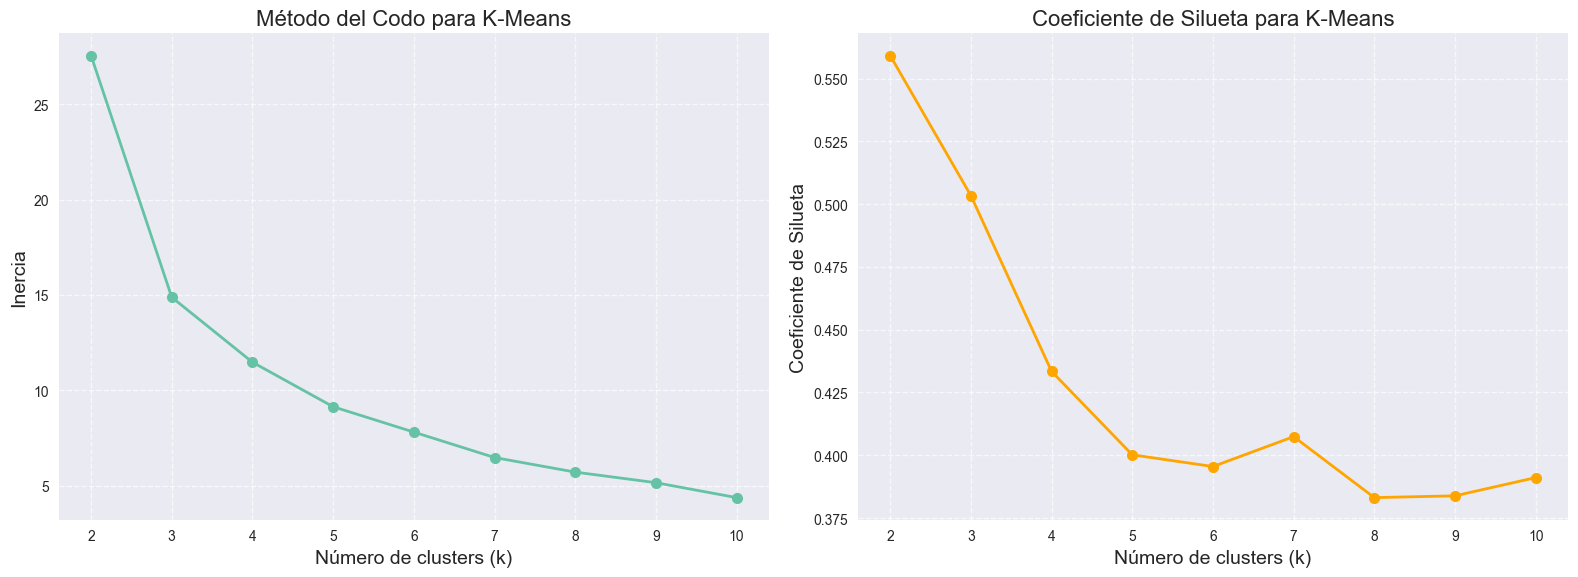

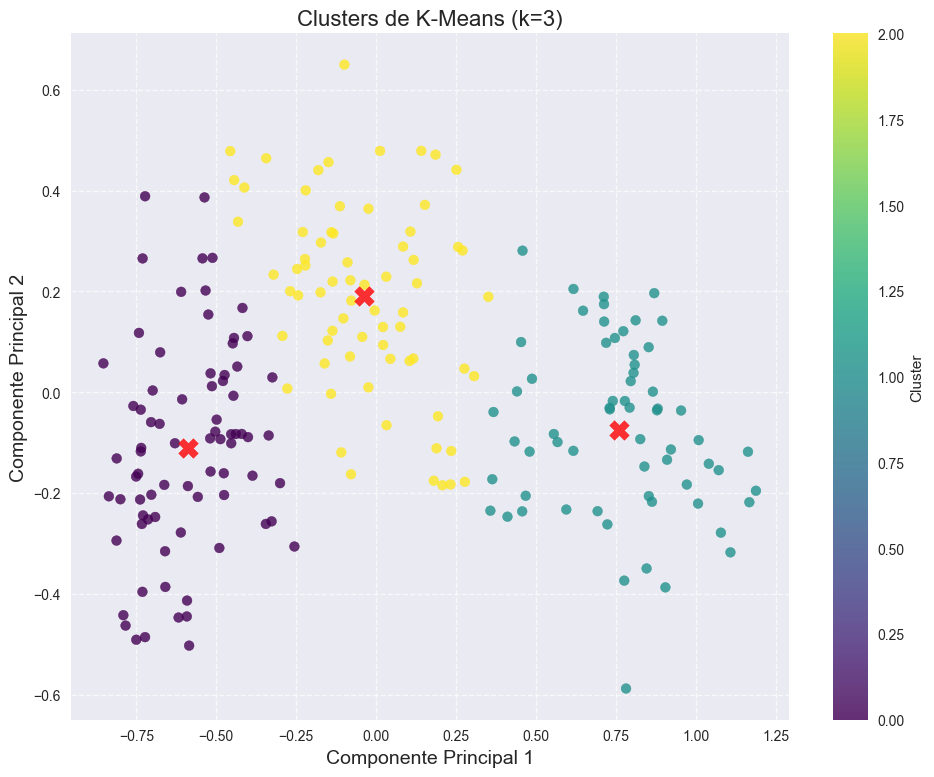


Tabla de contingencia (Clases reales vs. Clusters):
col_0   0   1   2
clase            
1      10   2  58
2       0  61   9
3      67   0   3

Pureza de los clusters: 0.8857


In [3]:
# Escalador seleccionado basado en visualización previa 
# (generalmente StandardScaler funciona bien para la mayoría de casos)
best_scaler = MinMaxScaler()

# Pipeline para transformar los datos
pipeline = Pipeline([
    ('scaler', best_scaler),
    ('pca', PCA(n_components=2, random_state=SEED))
])

# Transformamos los datos
X_pca = pipeline.fit_transform(X)

# Método del codo para K-Means
def plot_elbow_method(X, max_k=10):
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        
        # Calculamos el score de silueta
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(X, labels))
    
    # Graficamos el método del codo
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfica de inercia
    ax1.plot(k_range, inertias, 'o-', linewidth=2, markersize=8)
    ax1.set_title('Método del Codo para K-Means', fontsize=16)
    ax1.set_xlabel('Número de clusters (k)', fontsize=14)
    ax1.set_ylabel('Inercia', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Gráfica del score de silueta
    ax2.plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8, color='orange')
    ax2.set_title('Coeficiente de Silueta para K-Means', fontsize=16)
    ax2.set_xlabel('Número de clusters (k)', fontsize=14)
    ax2.set_ylabel('Coeficiente de Silueta', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return inertias, silhouette_scores

# Aplicamos el método del codo
inertias, silhouette_scores = plot_elbow_method(X_pca)

# Determinamos el valor óptimo de k basado en los resultados
k_optimal = 3  # Este valor debe ser ajustado según los resultados del método del codo

# Aplicamos K-Means con el valor óptimo de k
kmeans = KMeans(n_clusters=k_optimal, random_state=SEED, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

# Visualizamos los clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.8, marker='X')
plt.title(f'Clusters de K-Means (k={k_optimal})', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=14)
plt.ylabel('Componente Principal 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Evaluamos la pureza de los clusters comparando con las clases originales
def evaluate_cluster_purity(labels_true, labels_pred):
    contingency_matrix = pd.crosstab(labels_true, labels_pred)
    print("\nTabla de contingencia (Clases reales vs. Clusters):")
    print(contingency_matrix)
    
    # Calculamos la pureza (accuracy usando el mapeo óptimo)
    total = contingency_matrix.sum().sum()
    purity = contingency_matrix.max(axis=0).sum() / total
    print(f"\nPureza de los clusters: {purity:.4f}")
    
    return contingency_matrix

# Evaluamos la pureza de los clusters K-Means
kmeans_contingency = evaluate_cluster_purity(y, kmeans_labels)

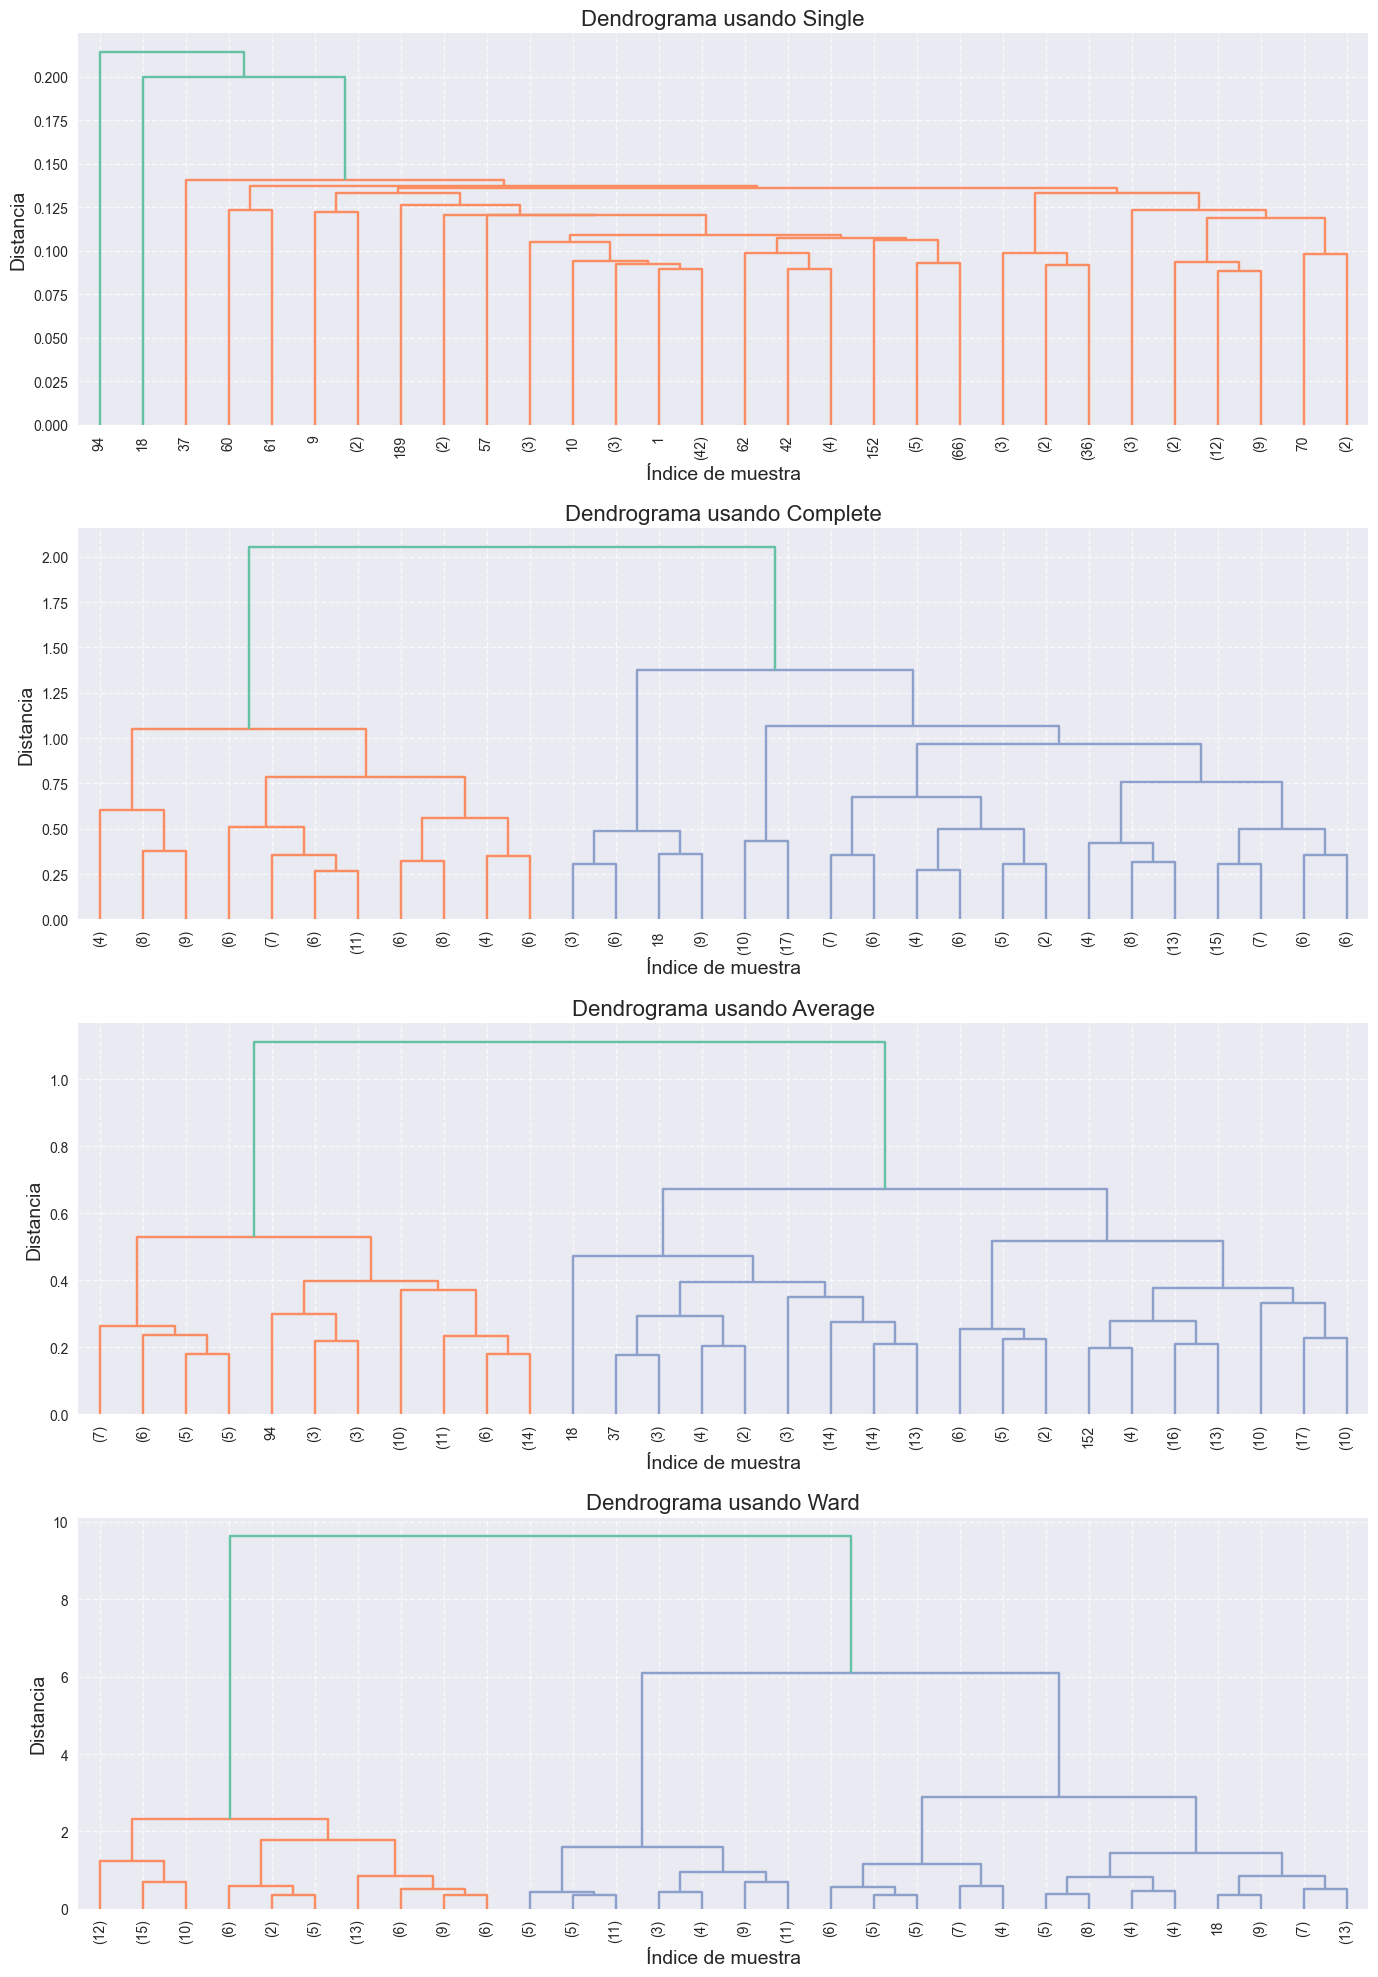

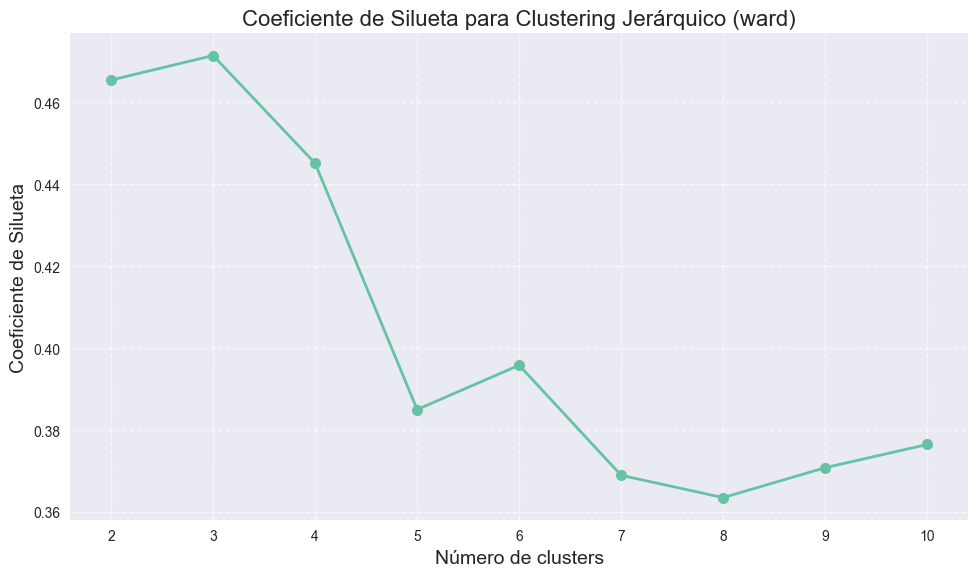

Número óptimo de clusters según coeficiente de silueta: 3


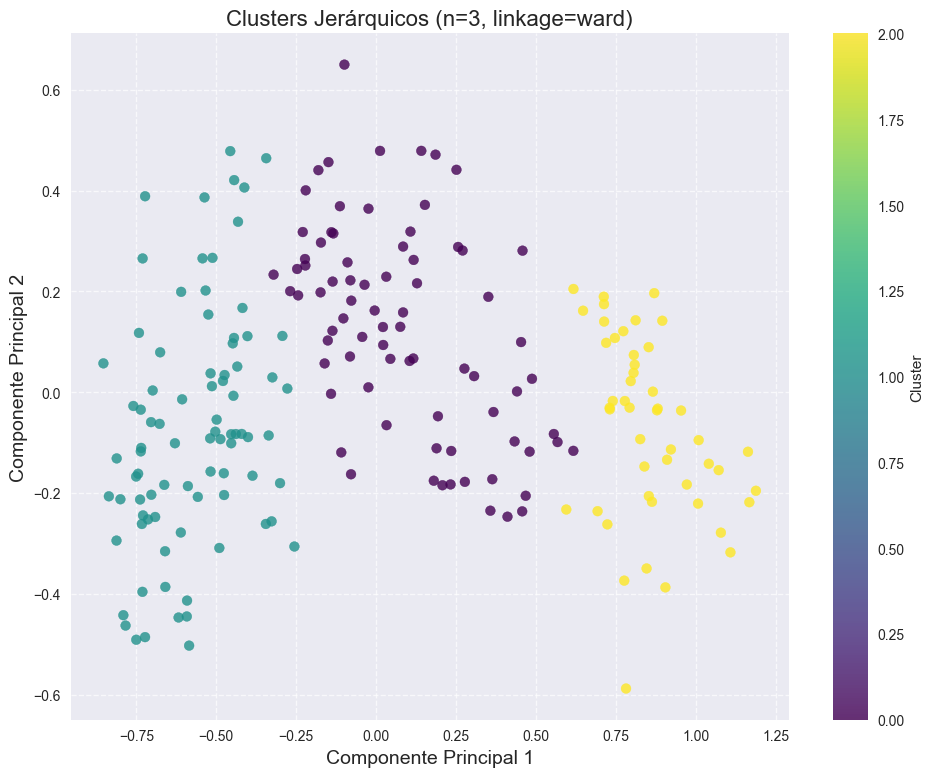


Tabla de contingencia (Clases reales vs. Clusters):
col_0   0   1   2
clase            
1      56  14   0
2      22   0  48
3       0  70   0

Pureza de los clusters: 0.8286


In [4]:
# Prueba de diferentes funciones de enlace (linkage)
linkage_methods = ['single', 'complete', 'average', 'ward']

# Función para visualizar dendrogramas
def plot_dendrogram(X, methods, truncate_mode=None, p=5):
    fig, axes = plt.subplots(len(methods), 1, figsize=(14, 5*len(methods)))
    
    for i, method in enumerate(methods):
        # Calcula la matriz de linkage
        linked = linkage(X, method=method)
        
        # Dibuja el dendrograma
        if len(methods) == 1:
            ax = axes
        else:
            ax = axes[i]
            
        dendrogram(linked, ax=ax, leaf_rotation=90, truncate_mode=truncate_mode, p=p)
        ax.set_title(f'Dendrograma usando {method.capitalize()}', fontsize=16)
        ax.set_xlabel('Índice de muestra', fontsize=14)
        ax.set_ylabel('Distancia', fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return linked

# Visualizamos los dendrogramas con diferentes métodos de linkage
# Para datasets grandes, usamos truncado para mejor visualización
linked = plot_dendrogram(X_pca, linkage_methods, truncate_mode='lastp', p=30)

# Seleccionamos un método de linkage basado en los dendrogramas
best_linkage = 'ward'  # A ajustar según resultados

# Probamos diferentes números de clusters
def test_hierarchical_clusters(X, y, method, max_clusters=10):
    n_clusters_range = range(2, max_clusters + 1)
    silhouette_scores = []
    
    for n_clusters in n_clusters_range:
        # Aplicamos clustering jerárquico
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
        labels = hierarchical.fit_predict(X)
        
        # Calculamos score de silueta
        silhouette_scores.append(silhouette_score(X, labels))
    
    # Graficamos scores de silueta
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters_range, silhouette_scores, 'o-', linewidth=2, markersize=8)
    plt.title(f'Coeficiente de Silueta para Clustering Jerárquico ({method})', fontsize=16)
    plt.xlabel('Número de clusters', fontsize=14)
    plt.ylabel('Coeficiente de Silueta', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Determinamos el número óptimo de clusters
    optimal_n = n_clusters_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"Número óptimo de clusters según coeficiente de silueta: {optimal_n}")
    
    return optimal_n, silhouette_scores

# Evaluamos diferentes números de clusters
hc_optimal_n, hc_silhouette_scores = test_hierarchical_clusters(X_pca, y, best_linkage)

# Aplicamos clustering jerárquico con parámetros optimizados
hierarchical = AgglomerativeClustering(n_clusters=hc_optimal_n, linkage=best_linkage)
hierarchical_labels = hierarchical.fit_predict(X_pca)

# Visualizamos los clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='viridis', s=50, alpha=0.8)
plt.title(f'Clusters Jerárquicos (n={hc_optimal_n}, linkage={best_linkage})', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=14)
plt.ylabel('Componente Principal 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Evaluamos la pureza
hc_contingency = evaluate_cluster_purity(y, hierarchical_labels)

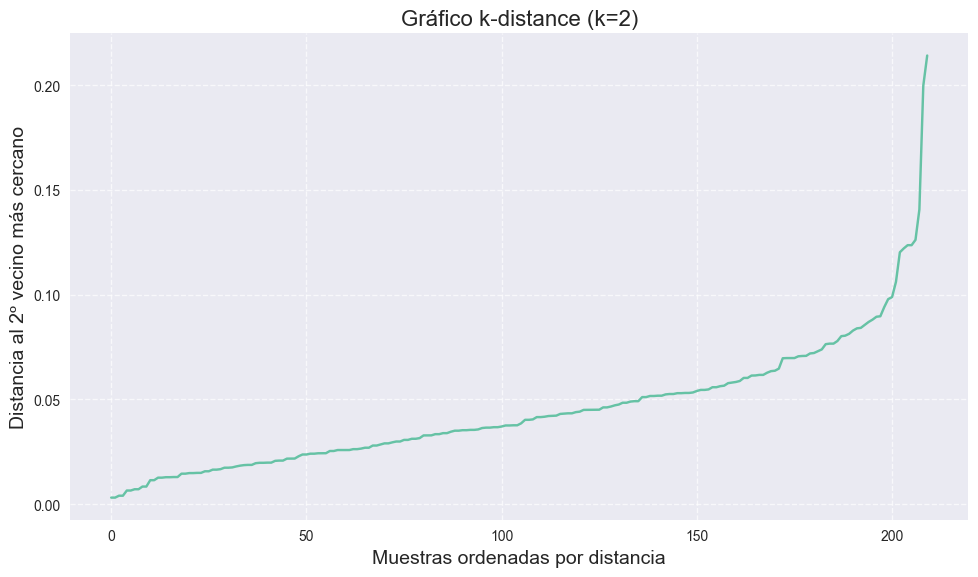

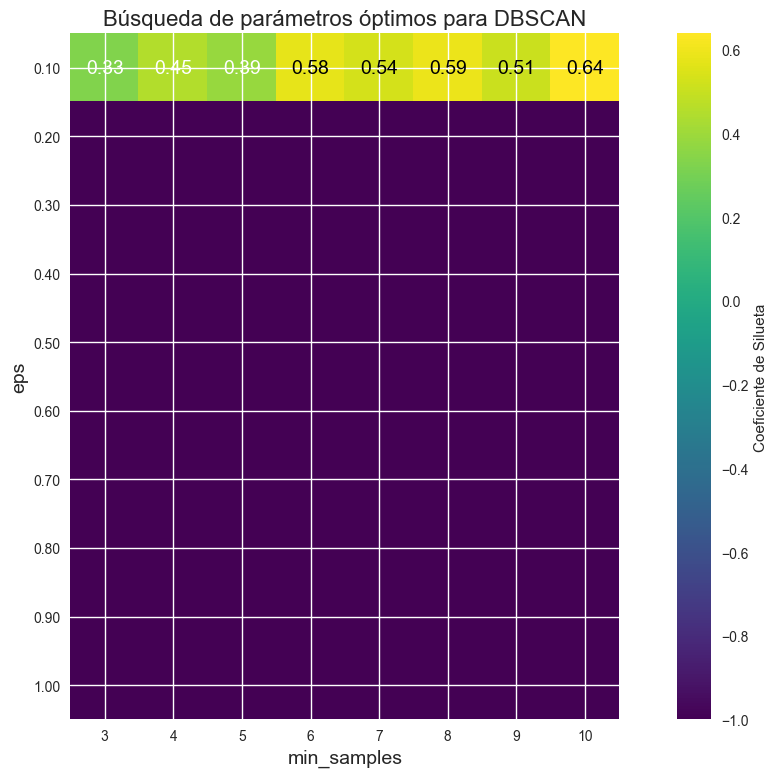

Mejores parámetros: eps=0.10, min_samples=10


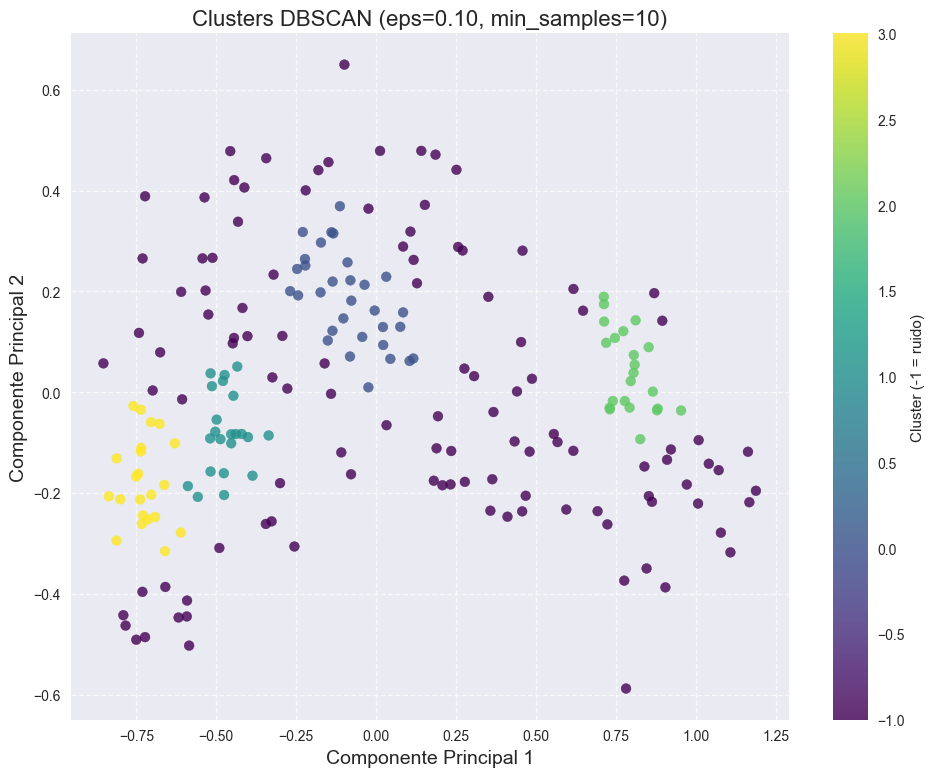

Número de clusters encontrados: 4
Número de puntos de ruido: 113 (53.81% del total)

Tabla de contingencia (Clases reales vs. Clusters):
col_0   0   1   2   3
clase                
1      31   1   0   0
2       0   0  22   0
3       0  21   0  22

Pureza de los clusters: 0.9897


In [5]:
# Encontramos los parámetros óptimos para DBSCAN
def find_optimal_dbscan_params(X, eps_range=None, min_samples_range=None):
    if eps_range is None:
        # Calculamos la distancia promedio a los k vecinos más cercanos
        from sklearn.neighbors import NearestNeighbors
        neighbors = NearestNeighbors(n_neighbors=2)
        neighbors_fit = neighbors.fit(X)
        distances, indices = neighbors_fit.kneighbors(X)
        
        # Ordenamos las distancias para el gráfico k-distance
        distances = np.sort(distances[:, 1])
        
        # Visualizamos el gráfico k-distance
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(distances)), distances)
        plt.title('Gráfico k-distance (k=2)', fontsize=16)
        plt.xlabel('Muestras ordenadas por distancia', fontsize=14)
        plt.ylabel('Distancia al 2º vecino más cercano', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Basado en el gráfico, seleccionamos un rango de epsilon
        eps_range = np.linspace(0.1, 1.0, 10)
    
    if min_samples_range is None:
        min_samples_range = range(3, 11)
    
    # Inicializamos matriz de resultados
    results = np.zeros((len(eps_range), len(min_samples_range)))
    best_silhouette = -1
    best_params = (0, 0)
    
    # Probamos diferentes combinaciones de parámetros
    for i, eps in enumerate(eps_range):
        for j, min_samples in enumerate(min_samples_range):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            # Calculamos silhouette_score solo si hay más de un cluster y no todos son ruido (-1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters > 1 and np.sum(labels != -1) > 0:
                # Calculamos el score solo para puntos no clasificados como ruido
                mask = labels != -1
                if np.sum(mask) > 1:
                    try:
                        score = silhouette_score(X[mask], labels[mask])
                        results[i, j] = score
                        
                        if score > best_silhouette:
                            best_silhouette = score
                            best_params = (eps, min_samples)
                    except:
                        # Si hay error (por ejemplo, solo un cluster no ruido), ponemos score -1
                        results[i, j] = -1
            else:
                results[i, j] = -1
    
    # Visualizamos los resultados como un mapa de calor
    plt.figure(figsize=(12, 8))
    heatmap = plt.imshow(results, cmap='viridis', interpolation='nearest')
    plt.colorbar(heatmap, label='Coeficiente de Silueta')
    plt.title('Búsqueda de parámetros óptimos para DBSCAN', fontsize=16)
    plt.xlabel('min_samples', fontsize=14)
    plt.ylabel('eps', fontsize=14)
    plt.xticks(range(len(min_samples_range)), min_samples_range)
    plt.yticks(range(len(eps_range)), [f'{eps:.2f}' for eps in eps_range])
    
    for i in range(len(eps_range)):
        for j in range(len(min_samples_range)):
            if results[i, j] >= 0:
                plt.text(j, i, f'{results[i, j]:.2f}', ha='center', va='center', 
                         color='white' if results[i, j] < 0.5 else 'black')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Mejores parámetros: eps={best_params[0]:.2f}, min_samples={best_params[1]}")
    return best_params

# Determinamos los mejores parámetros para DBSCAN
best_eps, best_min_samples = find_optimal_dbscan_params(X_pca)

# Aplicamos DBSCAN con los parámetros optimizados
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(X_pca)

# Visualizamos los clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', s=50, alpha=0.8)
plt.title(f'Clusters DBSCAN (eps={best_eps:.2f}, min_samples={best_min_samples})', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=14)
plt.ylabel('Componente Principal 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Cluster (-1 = ruido)')
plt.tight_layout()
plt.show()

# Contamos el número de puntos por cluster
unique_labels = set(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Número de clusters encontrados: {n_clusters}")
print(f"Número de puntos de ruido: {n_noise} ({n_noise/len(X_pca):.2%} del total)")

# Evaluamos la pureza (excluyendo puntos de ruido)
if -1 in dbscan_labels:
    # Creamos máscaras para excluir puntos de ruido
    non_noise_mask = dbscan_labels != -1
    dbscan_contingency = evaluate_cluster_purity(y[non_noise_mask], dbscan_labels[non_noise_mask])
else:
    dbscan_contingency = evaluate_cluster_purity(y, dbscan_labels)

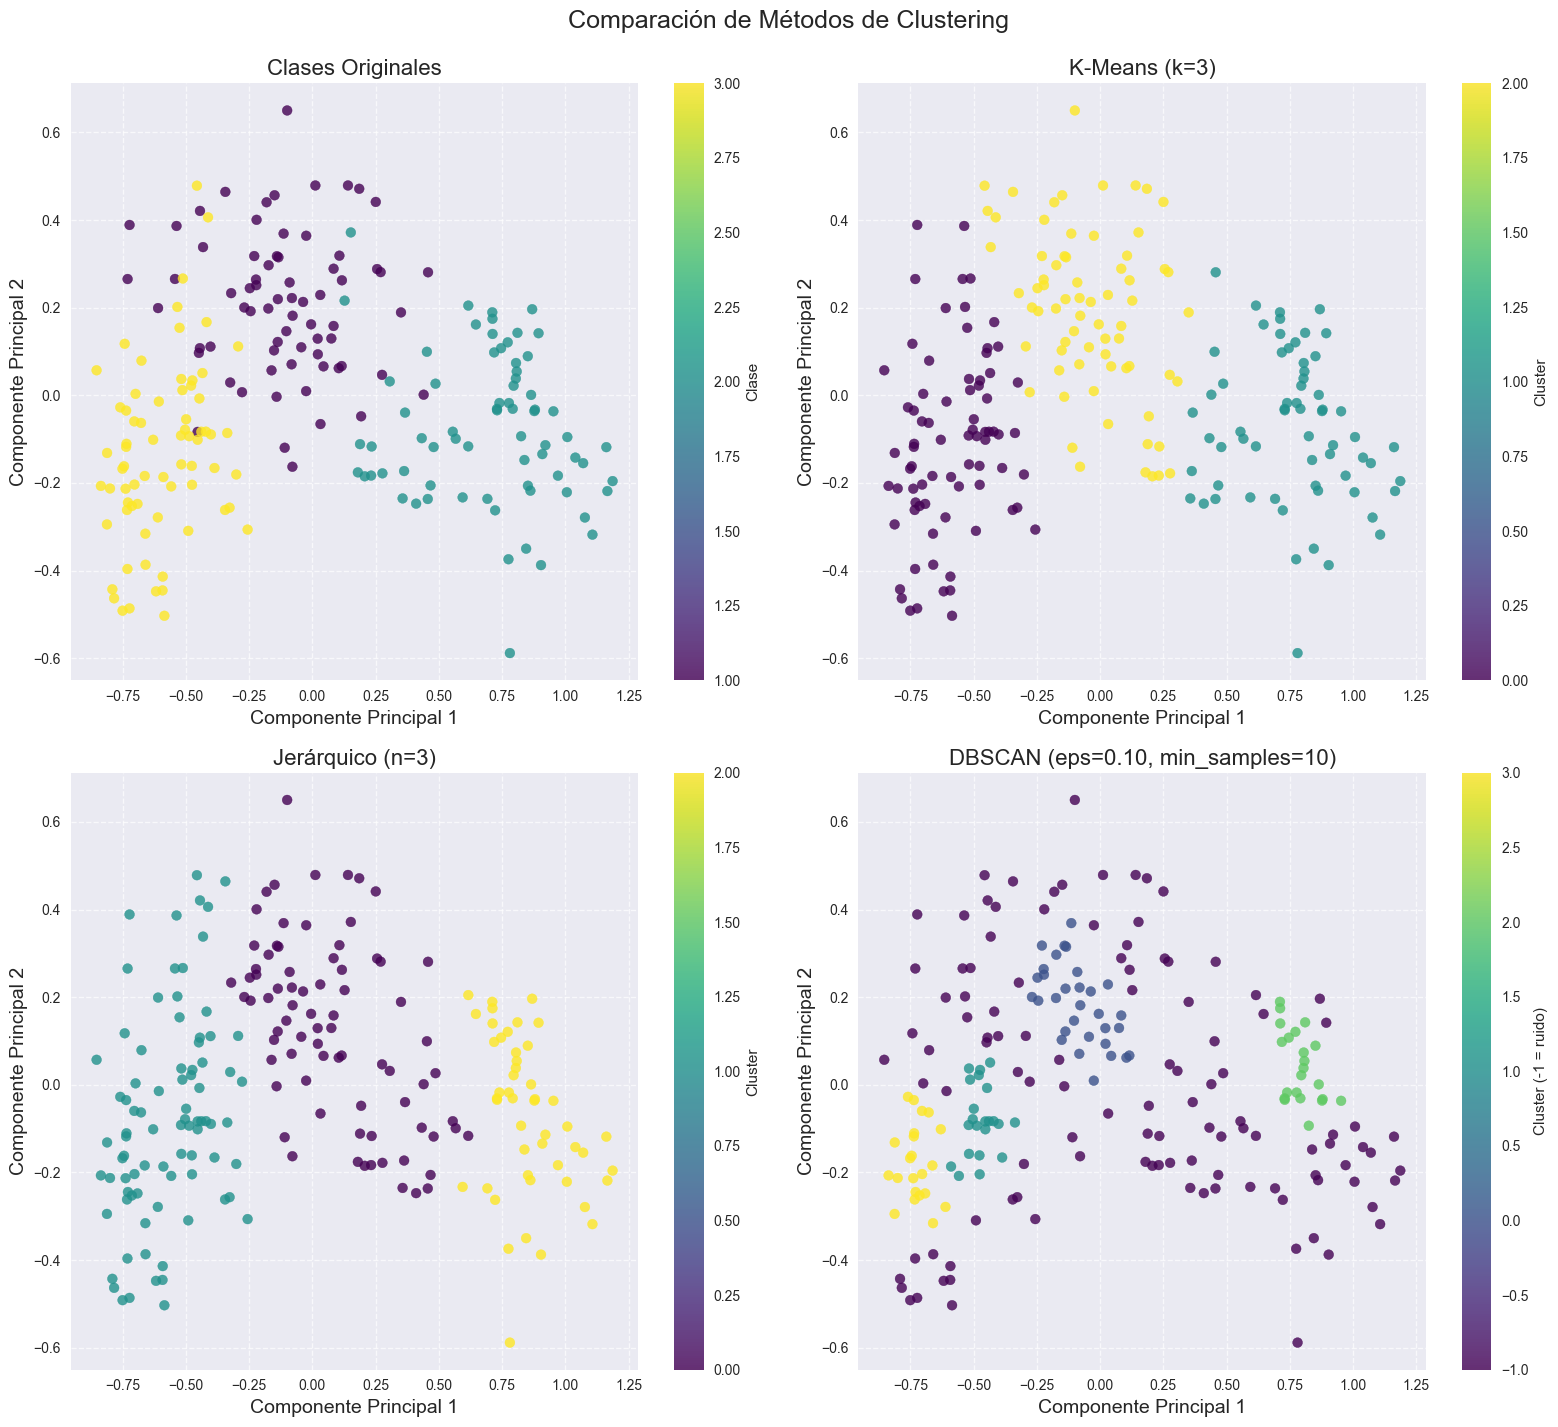

Comparación de métodos de clustering:
       Método  Número de clusters  Coeficiente de Silueta
0     K-Means                   3                0.503385
1  Jerárquico                   3                0.471405
2      DBSCAN                   4                0.639148


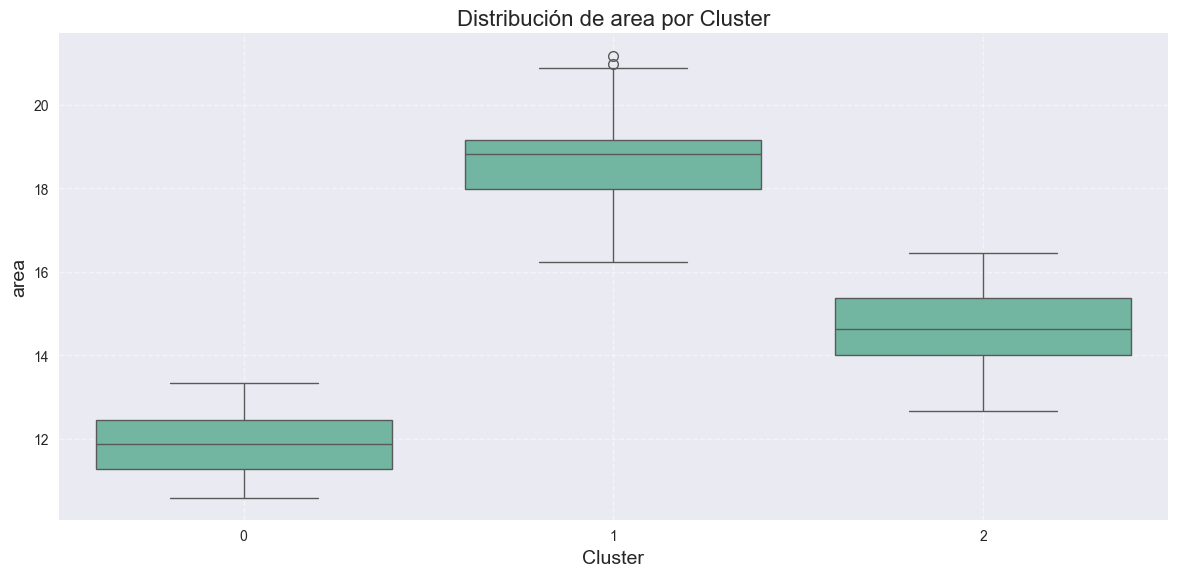

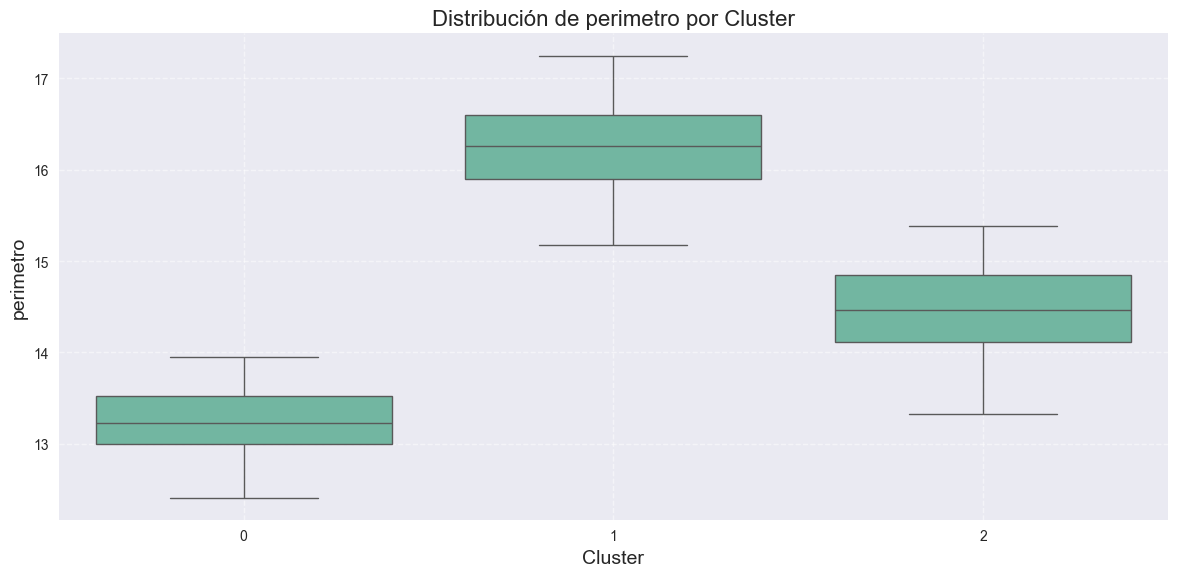

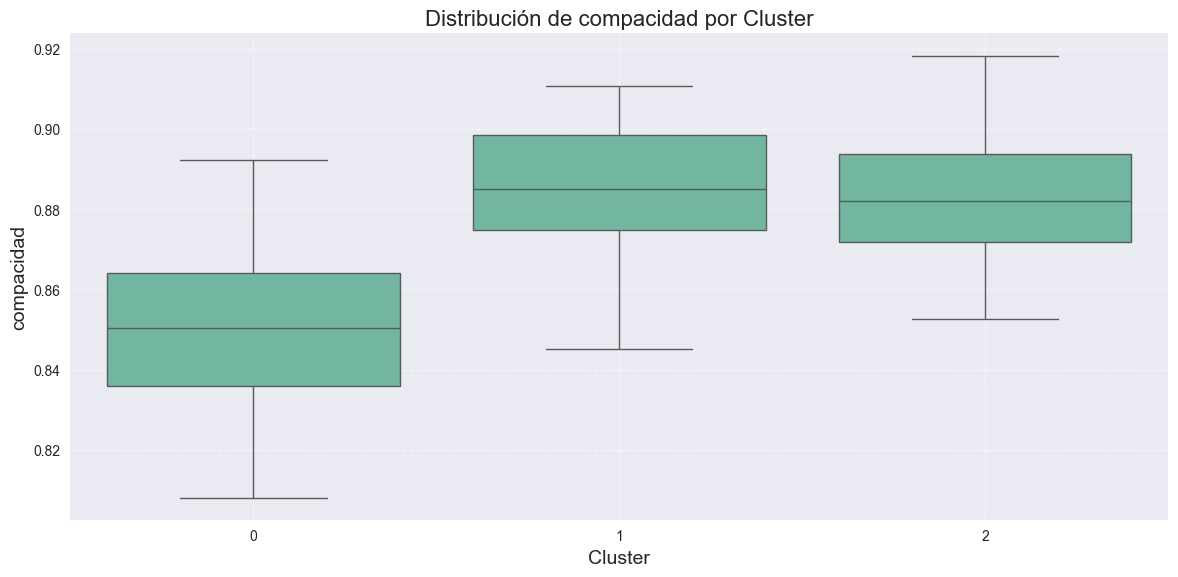

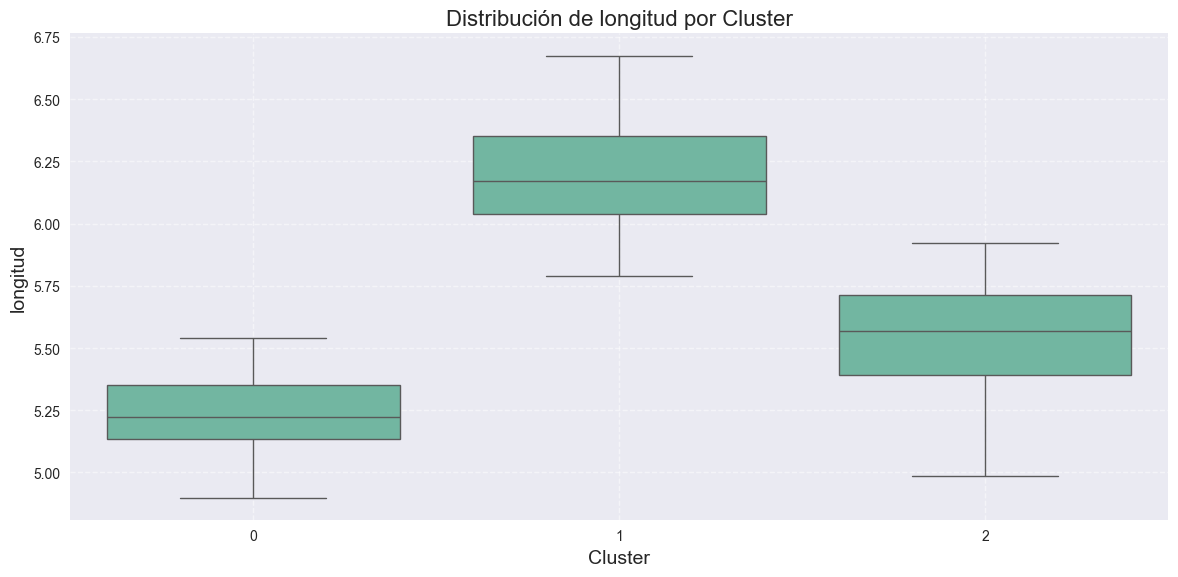

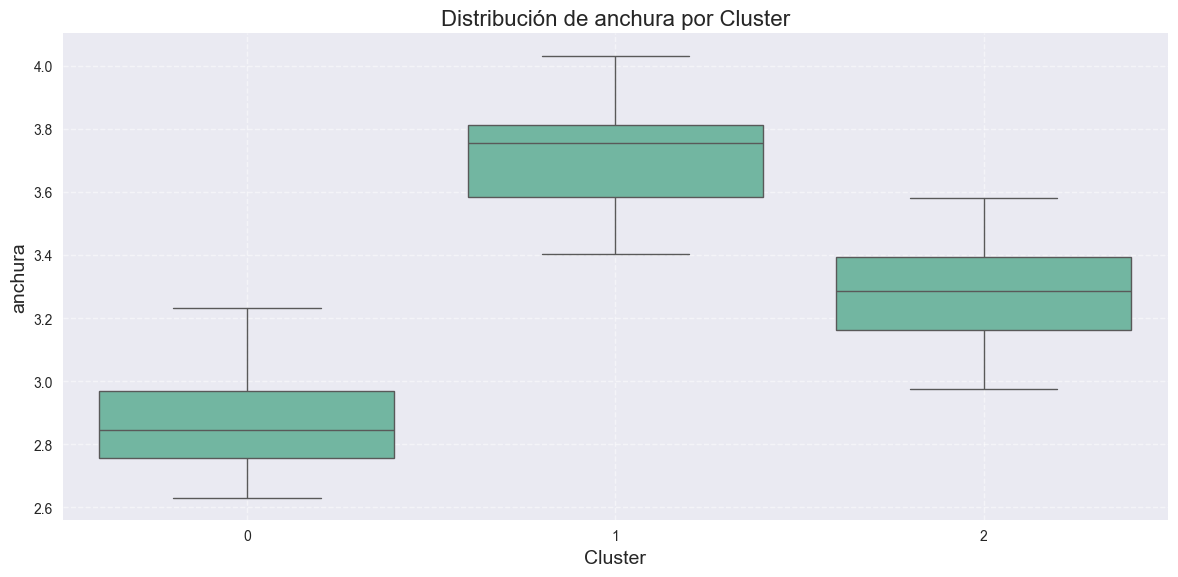

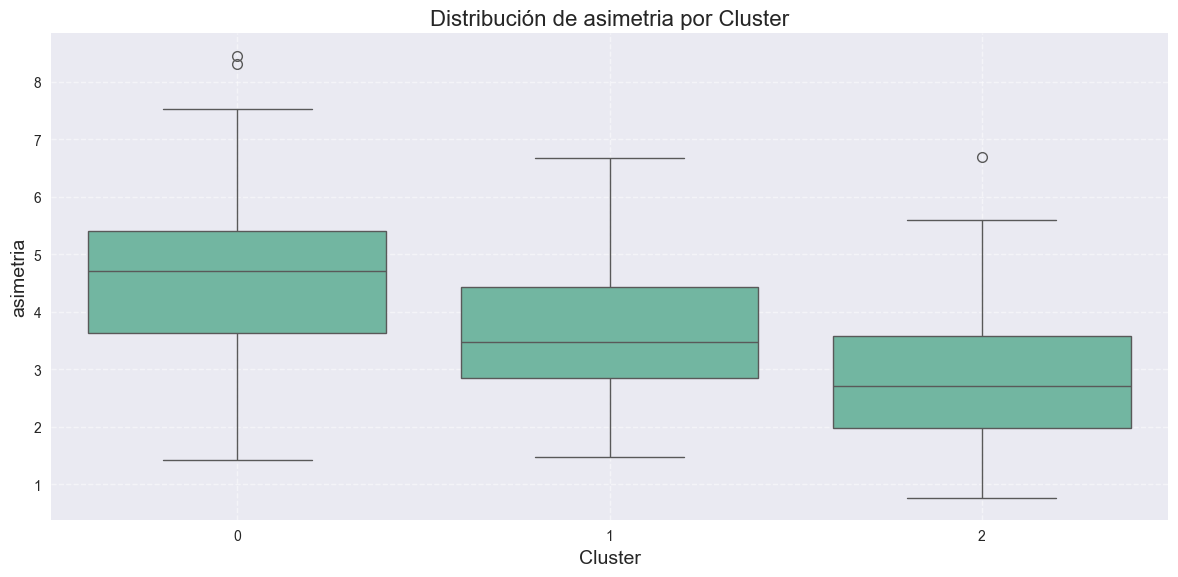

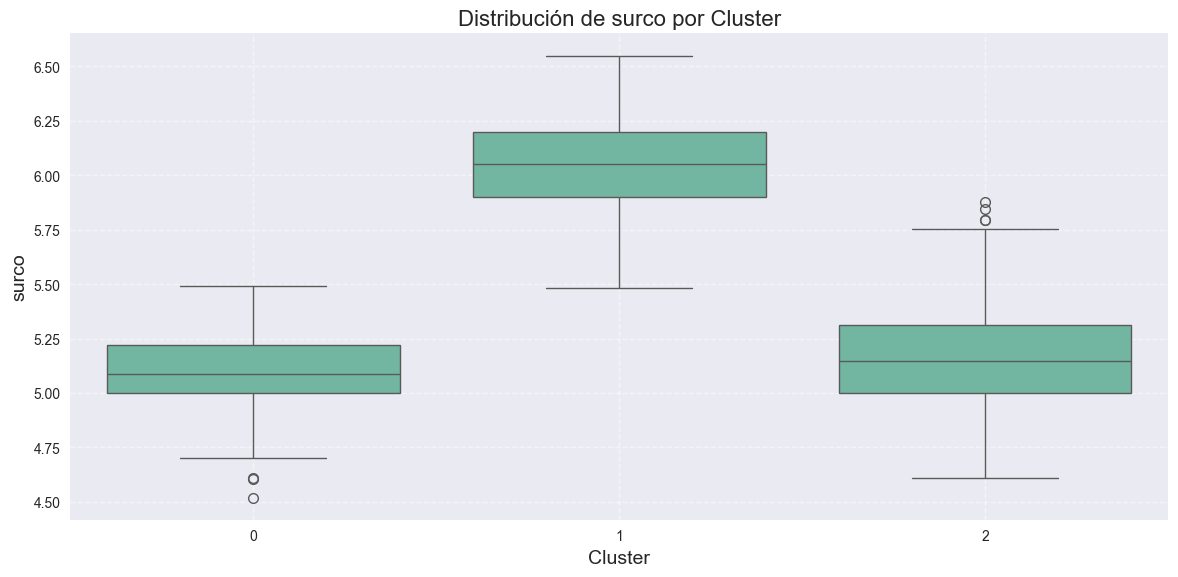

Estadísticas por cluster:
              area            perimetro           compacidad            \
              mean       std       mean       std       mean       std   
cluster                                                                  
0        11.896104  0.713157  13.257662  0.351773   0.849775  0.020403   
1        18.649048  1.152377  16.266349  0.498107   0.884921  0.014814   
2        14.672714  0.971726  14.454714  0.494332   0.881814  0.015402   

         longitud             anchura           asimetria               surco  \
             mean       std      mean       std      mean       std      mean   
cluster                                                                         
0        5.230597  0.142286  2.858026  0.138387  4.599545  1.430240  5.086234   
1        6.201111  0.221505  3.714603  0.155495  3.581397  1.229148  6.060810   
2        5.550943  0.214621  3.288843  0.139541  2.817846  1.237585  5.174629   

                   
              std  
cl

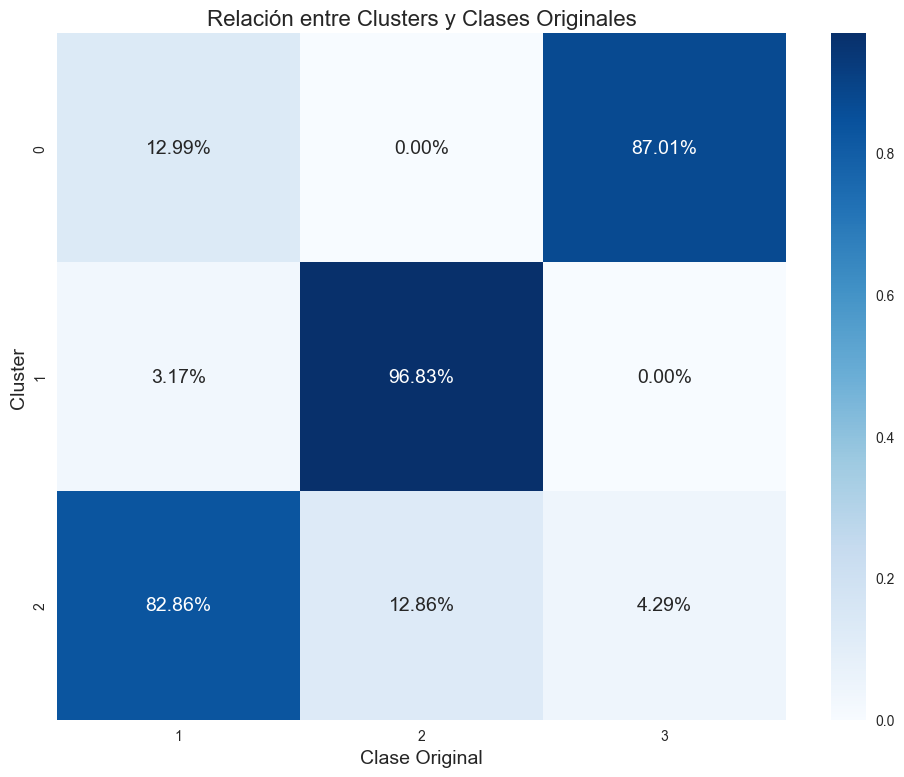

In [6]:
# Comparamos visualmente los tres métodos de clustering
def compare_clustering_methods(X, true_labels, kmeans_labels, hierarchical_labels, dbscan_labels):
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Etiquetas reales
    scatter1 = axes[0, 0].scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', s=50, alpha=0.8)
    axes[0, 0].set_title('Clases Originales', fontsize=16)
    axes[0, 0].set_xlabel('Componente Principal 1', fontsize=14)
    axes[0, 0].set_ylabel('Componente Principal 2', fontsize=14)
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)
    fig.colorbar(scatter1, ax=axes[0, 0], label='Clase')
    
    # K-Means
    scatter2 = axes[0, 1].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.8)
    axes[0, 1].set_title(f'K-Means (k={len(np.unique(kmeans_labels))})', fontsize=16)
    axes[0, 1].set_xlabel('Componente Principal 1', fontsize=14)
    axes[0, 1].set_ylabel('Componente Principal 2', fontsize=14)
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)
    fig.colorbar(scatter2, ax=axes[0, 1], label='Cluster')
    
    # Hierarchical
    scatter3 = axes[1, 0].scatter(X[:, 0], X[:, 1], c=hierarchical_labels, cmap='viridis', s=50, alpha=0.8)
    axes[1, 0].set_title(f'Jerárquico (n={len(np.unique(hierarchical_labels))})', fontsize=16)
    axes[1, 0].set_xlabel('Componente Principal 1', fontsize=14)
    axes[1, 0].set_ylabel('Componente Principal 2', fontsize=14)
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)
    fig.colorbar(scatter3, ax=axes[1, 0], label='Cluster')
    
    # DBSCAN
    scatter4 = axes[1, 1].scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', s=50, alpha=0.8)
    axes[1, 1].set_title(f'DBSCAN (eps={best_eps:.2f}, min_samples={best_min_samples})', fontsize=16)
    axes[1, 1].set_xlabel('Componente Principal 1', fontsize=14)
    axes[1, 1].set_ylabel('Componente Principal 2', fontsize=14)
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)
    fig.colorbar(scatter4, ax=axes[1, 1], label='Cluster (-1 = ruido)')
    
    plt.tight_layout()
    plt.suptitle('Comparación de Métodos de Clustering', y=1.02, fontsize=18)
    plt.show()

# Comparamos los diferentes métodos de clustering
compare_clustering_methods(X_pca, y, kmeans_labels, hierarchical_labels, dbscan_labels)

# Comparamos métricas de evaluación
def compare_clustering_metrics(y_true, kmeans_labels, hierarchical_labels, dbscan_labels):
    # Calculamos silhouette score para cada método
    kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
    hc_silhouette = silhouette_score(X_pca, hierarchical_labels)
    
    # Para DBSCAN, solo consideramos puntos no ruido
    if -1 in dbscan_labels:
        non_noise_mask = dbscan_labels != -1
        if np.sum(non_noise_mask) > 1:  # Comprobamos que hay suficientes puntos no ruido
            dbscan_silhouette = silhouette_score(X_pca[non_noise_mask], dbscan_labels[non_noise_mask])
        else:
            dbscan_silhouette = float('nan')
    else:
        dbscan_silhouette = silhouette_score(X_pca, dbscan_labels)
    
    # Comparamos resultados
    results = pd.DataFrame({
        'Método': ['K-Means', 'Jerárquico', 'DBSCAN'],
        'Número de clusters': [len(np.unique(kmeans_labels)), 
                              len(np.unique(hierarchical_labels)), 
                              len(np.unique(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)],
        'Coeficiente de Silueta': [kmeans_silhouette, hc_silhouette, dbscan_silhouette]
    })
    
    print("Comparación de métodos de clustering:")
    print(results)
    
    return results

# Comparamos métricas entre los diferentes métodos
comparison_results = compare_clustering_metrics(y, kmeans_labels, hierarchical_labels, dbscan_labels)

# Interpretación de clusters: analizamos las características por cluster
def analyze_clusters(X_orig, clusters, feature_names):
    # Añadimos las etiquetas de cluster a los datos originales
    df_analysis = X_orig.copy()
    df_analysis['cluster'] = clusters
    
    # Boxplots para cada característica por cluster
    for feature in feature_names:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='cluster', y=feature, data=df_analysis)
        plt.title(f'Distribución de {feature} por Cluster', fontsize=16)
        plt.xlabel('Cluster', fontsize=14)
        plt.ylabel(feature, fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    
    # Estadísticas descriptivas por cluster
    cluster_stats = df_analysis.groupby('cluster').agg(['mean', 'std'])
    print("Estadísticas por cluster:")
    print(cluster_stats)
    
    return cluster_stats

# Elegimos el mejor método de clustering basado en las métricas
# (ajustar según los resultados obtenidos)
best_clustering_labels = kmeans_labels  # Por ejemplo, si K-Means resultó ser el mejor

# Analizamos las características por cluster para el mejor método
feature_names = X.columns
best_cluster_stats = analyze_clusters(X, best_clustering_labels, feature_names)

# Relación entre clusters y clases originales
def analyze_clusters_vs_classes(clusters, true_labels):
    # Creamos un dataframe con clusters y clases
    df_comparison = pd.DataFrame({
        'cluster': clusters,
        'clase_original': true_labels
    })
    
    # Tabla de contingencia y visualización
    contingency = pd.crosstab(df_comparison['cluster'], 
                             df_comparison['clase_original'], 
                             normalize='index')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(contingency, annot=True, cmap='Blues', fmt='.2%')
    plt.title('Relación entre Clusters y Clases Originales', fontsize=16)
    plt.xlabel('Clase Original', fontsize=14)
    plt.ylabel('Cluster', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return contingency

# Analizamos la relación entre los clusters y las clases originales
cluster_class_relation = analyze_clusters_vs_classes(best_clustering_labels, y)